In [1]:
package_paths = [r"C:\Users\benja\Documents\projects\goalscorers"]
import sys
for path in package_paths:
    sys.path.append(path)
import goalscorer_package.constants as c
import goalscorer_package.data_cleaning as dc
import goalscorer_package.modelling as m
import datetime as dt
import pandas as pd
import numpy as np
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import arviz as az
print(f"Running on Az v{az.__version__}")
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import glob
from statistics import mode
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 100)
pd.options.display.float_format = "{: ,.3f}".format
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)
%config InlineBackend.figure_formats = ["retina"]

Running on PyMC v5.6.1
Running on Az v0.16.0


# Model description

$$
X_{i, k} \sim \text{Exponential}(\lambda=1 / \eta_{i, k}\tau_{i, k})  \\  
$$
$$
\eta_{i, k} = \text{exp}(\gamma + \Delta_i - \beta_{op} + P_{i, k})  \\  
$$
Constrain:  
$\sum_{op} \beta_{op} = 0$  

Where:  
$k$ - match  
$i$ - player_id  
  
$\gamma$ - home advantage  
$\Delta$ - player_id goal scoring propensity  
$\beta$ - team propensity to prevent goals - where average team is 0  
$P$ - player_id position prpoensity to score goals  

# Data

In [2]:
seasons = ["2017-2018"]
comp_ids = [9, 10, 11, 12, 13, 20]

In [3]:
def data(seasons: list[str], comp_ids: list[int]) -> pd.DataFrame:
    seasons_leagues = dc.get_seasons_leagues_from_str(seasons, comp_ids)
    df = dc.load_seasons_leagues_files("summary", True, seasons_leagues)
    df = dc.split_positions(df)
    df = dc.position_to_generic_position(df)
    df = dc.add_frac_90(df)
    df = dc.add_home(df)
    df = dc.add_opp_team(df)
    df = dc.drop_gk(df)
    df = dc.drop_na_npxg(df)
    df = dc.drop_na_frac_90(df)
    df = dc.add_league(df)
    df["league_10"] = np.where((df.league == 10), 1, 0)
    return df

In [4]:
df = data(seasons, comp_ids)

In [5]:
df_model = df[["npxg", "player_id", "home", "opposition_team", "frac_90", "start", "position", "league", "league_10", "squad"]].copy()
df_model.head()

npxg player_id  home opposition_team  frac_90  start position  league  \
0  0.300  9dbb75ca     1  Leicester City    1.000   True       FW       9   
1  1.000  ce5143da     1  Leicester City    0.822   True       AM       9   
2  0.000  1ecb65be     1  Leicester City    0.178  False        W       9   
3  0.100  16380240     1  Leicester City    1.000   True       AM       9   
4  0.100  e61b8aee     1  Leicester City    1.000   True       CM       9   

   league_10    squad  
0          0  Arsenal  
1          0  Arsenal  
2          0  Arsenal  
3          0  Arsenal  
4          0  Arsenal

# Model

## Priors

In [6]:
# Delta prior params
perc_sigma_increase = 0.0
dict_player_id_position_based_priors = {
    "FB": (-3.32, 0.86 * (1.0 + perc_sigma_increase/100.0)),
    "CB": (-2.75, 0.74 * (1.0 + perc_sigma_increase/100.0)),
    "WB": (-3.08, 0.73 * (1.0 + perc_sigma_increase/100.0)),
    "DM": (-3.13, 0.82 * (1.0 + perc_sigma_increase/100.0)),
    "CM": (-3.04, 0.86 * (1.0 + perc_sigma_increase/100.0)),
    "WM": (-2.55, 0.68 * (1.0 + perc_sigma_increase/100.0)),
    "AM": (-2.20, 0.56 * (1.0 + perc_sigma_increase/100.0)),
    "W": (-2.06, 0.50 * (1.0 + perc_sigma_increase/100.0)),
    "FW": (-1.70, 0.38 * (1.0 + perc_sigma_increase/100.0)),
}

In [7]:
dict_player_id_position_based_mins = {
    "FB": -4.02,
    "CB": -3.98,
    "WB": -4.68,
    "DM": -4.51,
    "CM": -4.52,
    "WM": -4.81,
    "AM": -4.99,
    "W": -4.96,
    "FW": -5.05,
}

In [8]:
# position prior params
perc_sigma_increase = 0.0
dict_position_priors = {
    "FB": (-0.59, 0.037 * (1.0 + perc_sigma_increase/100.0)),
    "CB": (-0.63, 0.043 * (1.0 + perc_sigma_increase/100.0)),
    "WB": (0.076, 0.044 * (1.0 + perc_sigma_increase/100.0)),
    "DM": (-0.098, 0.032 * (1.0 + perc_sigma_increase/100.0)),
    "CM": (-0.089, 0.027 * (1.0 + perc_sigma_increase/100.0)),
    "WM": (0.20, 0.025 * (1.0 + perc_sigma_increase/100.0)),
    "AM": (0.38, 0.036 * (1.0 + perc_sigma_increase/100.0)),
    "W": (0.30, 0.029 * (1.0 + perc_sigma_increase/100.0)),
    "FW": (0.45, 0.040 * (1.0 + perc_sigma_increase/100.0)),
}

In [9]:
player_id_codes, player_ids = pd.factorize(df_model.loc[:, "player_id"], sort=True)
team_codes, teams = pd.factorize(df_model.loc[:, "opposition_team"], sort=True)
position_codes, positions = pd.factorize(df_model.loc[:, "position"], sort=True)
league_codes, leagues = pd.factorize(df_model.loc[:, "league"], sort=True)

coords = {"player_ids": player_ids, "teams": teams, "positions": positions}

In [10]:
league_masks = m.create_league_masks(df_model, teams, leagues)

In [11]:
# create player_id priors

df_player_id_priors = (
    df_model
    .groupby("player_id", as_index=False)
    .agg(position=("position", mode), squad=("squad", mode), league=("league", mode))
    .assign(
        mu=lambda x: [dict_player_id_position_based_priors[pos][0] for pos in x.position.values] - np.where((x.league == 10), 0.4, 0.0),
        sigma=lambda x: [dict_player_id_position_based_priors[pos][1] for pos in x.position.values],
        lower=lambda x: [dict_player_id_position_based_mins[pos] for pos in x.position.values] ,
    )
    .set_index("player_id", drop=False)
    .loc[player_ids]
)

In [12]:
# create position priors

position_mus = [dict_position_priors[position][0] for position in positions]
position_sigmas = [dict_position_priors[position][1] for position in positions]

df_position_priors = (
    pd.DataFrame({"player_id": player_ids})
    .assign(
        mu=lambda x: [position_mus for _ in range(len(x))],
        sigma=lambda x: [position_sigmas for _ in range(len(x))],
    )
)

## Fit

In [13]:
# Weighted Exponential
def logp(value: pt.TensorVariable, lam: pt.TensorVariable, w: pt.TensorVariable) -> pt.TensorVariable:
    log_prob = w * (np.log(lam) - lam * value)
    return log_prob

def random(lam, w, rng=None, size=None):
    return scipy.stats.expon.rvs(scale=1.0/lam, size=size)

In [14]:
with pm.Model(coords=coords) as model:
    # Data
    home_data = pm.MutableData("home_data", df_model.home.values)
    player_id_codes_data = pm.MutableData("player_id_codes_data", player_id_codes)
    team_codes_data = pm.MutableData("team_codes_data", team_codes)
    position_codes_data = pm.MutableData("position_codes_data", position_codes)
    league_10_data = pm.MutableData("league_10_data", df_model.league_10.values)
    frac_90_data = pm.MutableData("frac_90_data", df_model.frac_90.values)
    npxg_data = pm.MutableData("npxg_data", df_model.npxg.values)

    # Priors
    γ = pm.Normal("γ", mu=np.array([0.2]), sigma=np.array([0.064]))
    Δ = pm.TruncatedNormal("Δ", mu=df_player_id_priors.mu.values, sigma=df_player_id_priors.sigma.values, 
                           lower=df_player_id_priors.lower.values, dims="player_ids")
    β_ = pm.Normal("β_", mu=0.0, sigma=0.22, dims="teams")
    P = pm.Normal("P", mu=np.array([list(x) for x in df_position_priors.mu.values]), 
                  sigma=np.array([list(x) for x in df_position_priors.sigma.values]), dims=("player_ids", "positions"))
    l_10 = 0.4

    # Deterministic transform
    for league_mask in league_masks:
        β_ = pt.add(β_, -(pt.sum(league_mask * β_) / pt.sum(league_mask)) * league_mask)
    β = pm.Deterministic("β", β_, dims="teams")

    η = pm.Deterministic("η", pt.exp(
        γ * home_data
        + Δ[player_id_codes_data]
        - β[team_codes_data]
        + P[player_id_codes_data, position_codes_data]
        + l_10 * league_10_data
    ))
    τ = frac_90_data

    exp = pm.Deterministic("exp", 1/(η * τ))
    # exp = pt.switch(pt.lt(exp, 0.001), 0.001, exp)

    # Likelihood
    x = pm.CustomDist(
        "x",
        exp, frac_90_data,
        logp=logp,
        random=random,
        observed=npxg_data
    )
    # x = pm.Exponential("x", lam=exp, observed=df_model["npxg"].values)

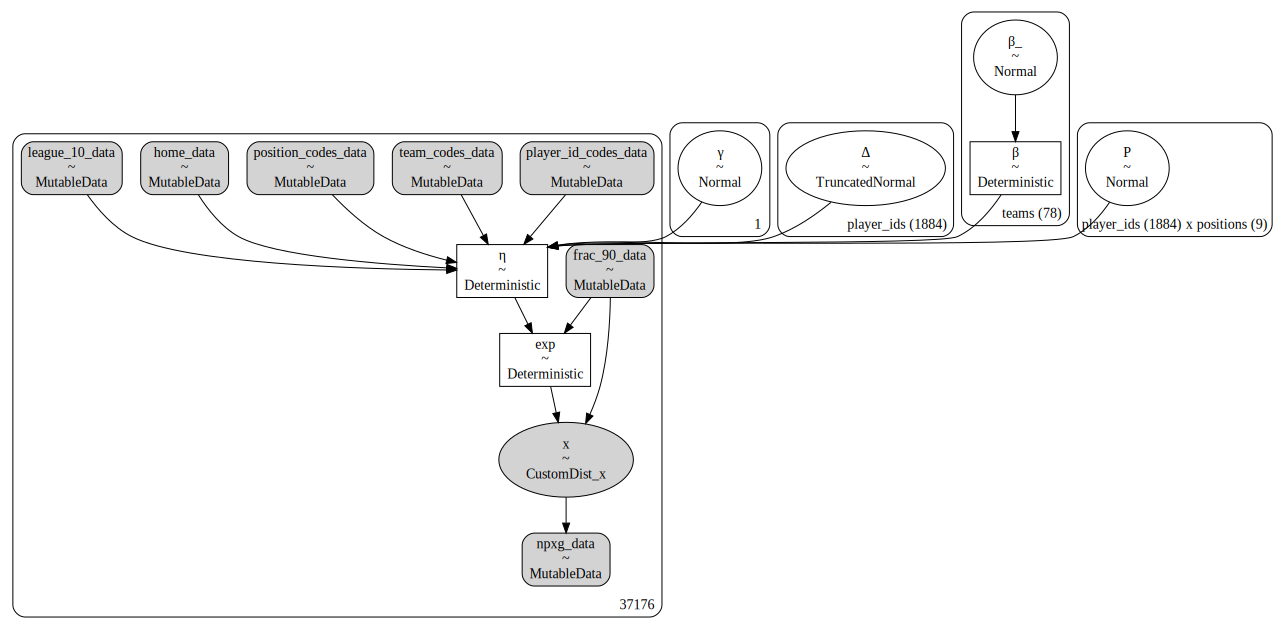

In [15]:
pm.model_to_graphviz(model)

### Prior Predictive

In [16]:
with model:
    prior = pm.sample_prior_predictive(samples=1000)

Sampling: [P, x, Δ, β_, γ]


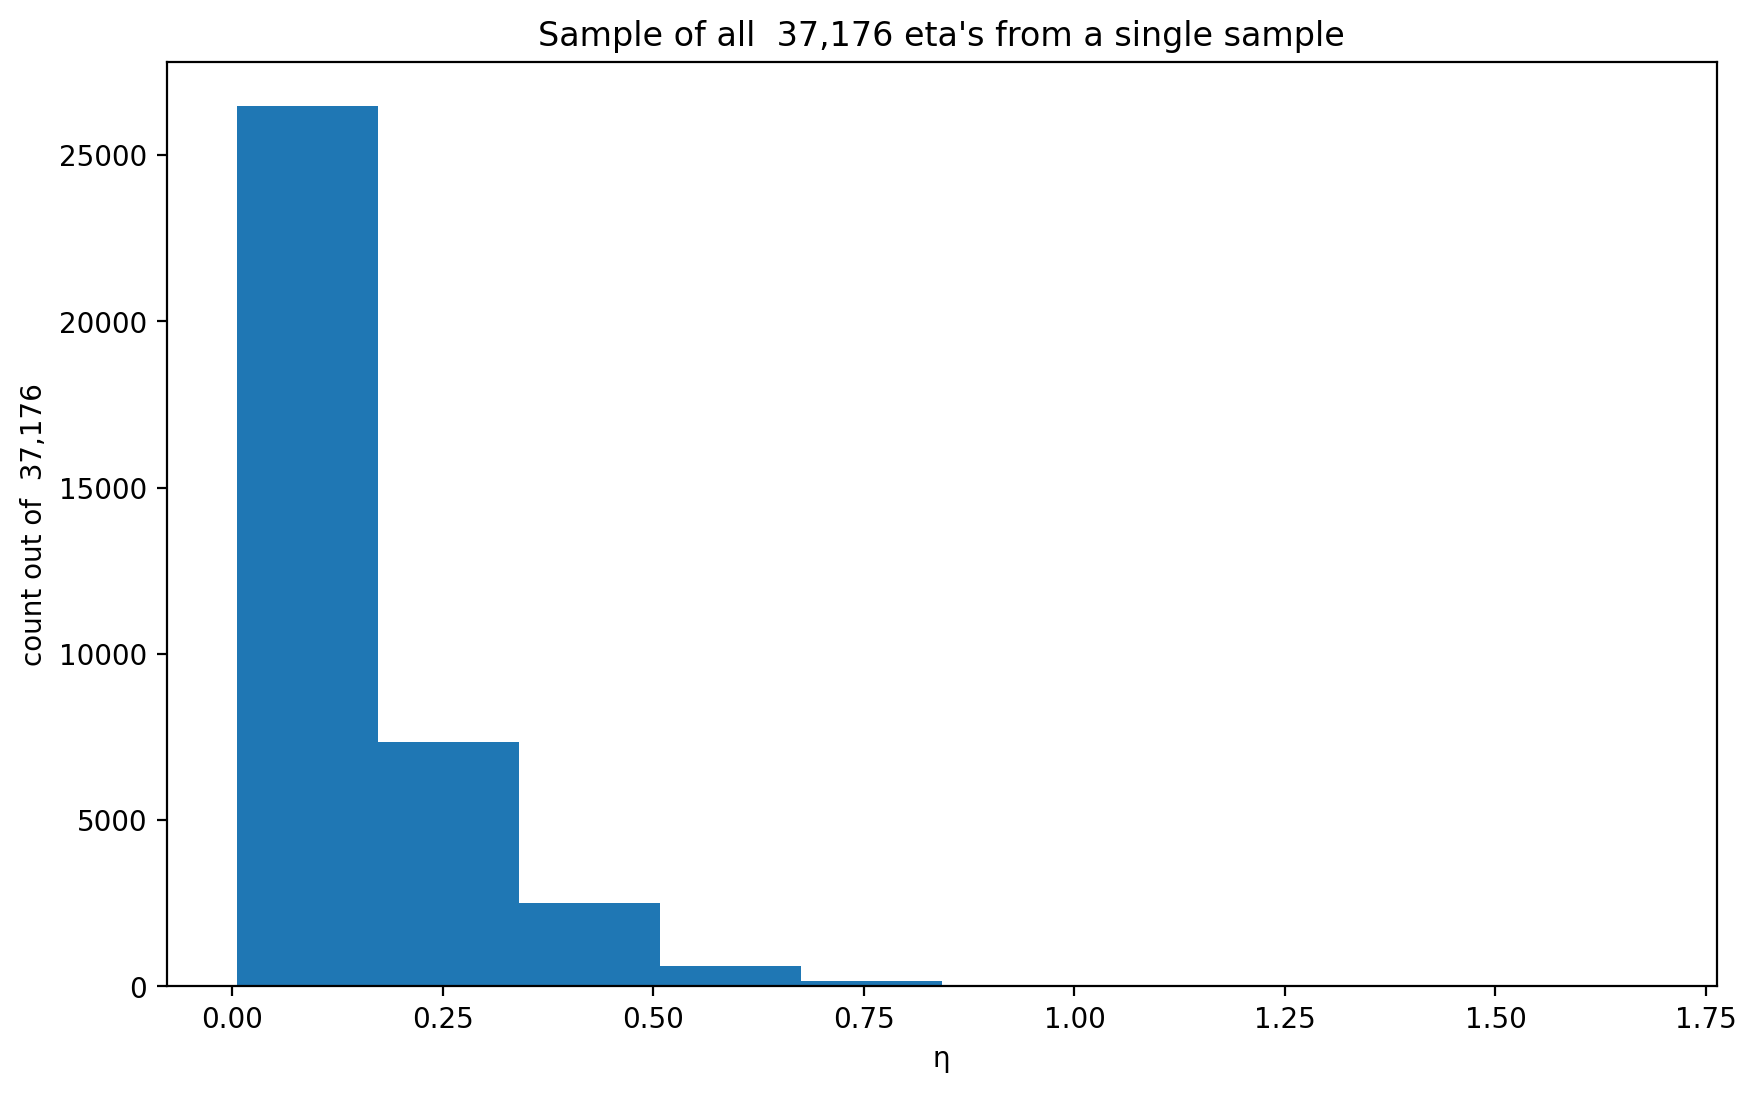

In [17]:
# sample of all eta's form a single sim

plt.hist(prior.prior.η.sel(chain=0, draw=0).data)
plt.title(f"Sample of all {len(df_model): ,} eta's from a single sample")
plt.xlabel("η")
plt.ylabel(f"count out of {len(df_model): ,}");

Vast majority of $\eta$ < 1, which is sensible.

### Sample

In [18]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, Δ, β_, P]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1273 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


### MCMC Diagnostics

R-hat value < 1.1 => Good

In [19]:
az.summary(idata, var_names=["γ", "Δ", "β"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
γ[0]                     0.189  0.012   0.167    0.211      0.000    0.000   
Δ[0000acda]             -2.301  0.179  -2.631   -1.965      0.002    0.001   
Δ[000b3da6]             -3.484  0.240  -3.947   -3.063      0.003    0.002   
Δ[003a5c72]             -2.584  0.198  -2.959   -2.228      0.002    0.002   
Δ[00459419]             -1.633  0.177  -1.985   -1.315      0.002    0.002   
...                        ...    ...     ...      ...        ...      ...   
β[Watford]              -0.085  0.055  -0.189    0.016      0.001    0.001   
β[Werder Bremen]        -0.032  0.056  -0.140    0.071      0.001    0.001   
β[West Bromwich Albion] -0.087  0.055  -0.193    0.013      0.001    0.001   
β[West Ham United]      -0.140  0.053  -0.237   -0.038      0.001    0.000   
β[Wolfsburg]            -0.206  0.056  -0.315   -0.106      0.001    0.000   

                          ess_bulk   ess_tail  r_hat  
γ[0]                     2,742.000  2,987.000  1.000  
Δ[0000acda]              8,006.000  2,678.000  1.000  
Δ[000b3da6]              5,985.000  2,679.000  1.000  
Δ[003a5c72]              6,834.000  2,565.000  1.000  
Δ[00459419]              5,596.000  2,944.000  1.000  
...                            ...        ...    ...  
β[Watford]               6,410.000  3,263.000  1.000  
β[Werder Bremen]         6,159.000  2,823.000  1.000  
β[West Bromwich Albion]  6,822.000  2,969.000  1.010  
β[West Ham United]       7,063.000  3,274.000  1.000  
β[Wolfsburg]             7,088.000  2,940.000  1.000  

[1963 rows x 9 columns]

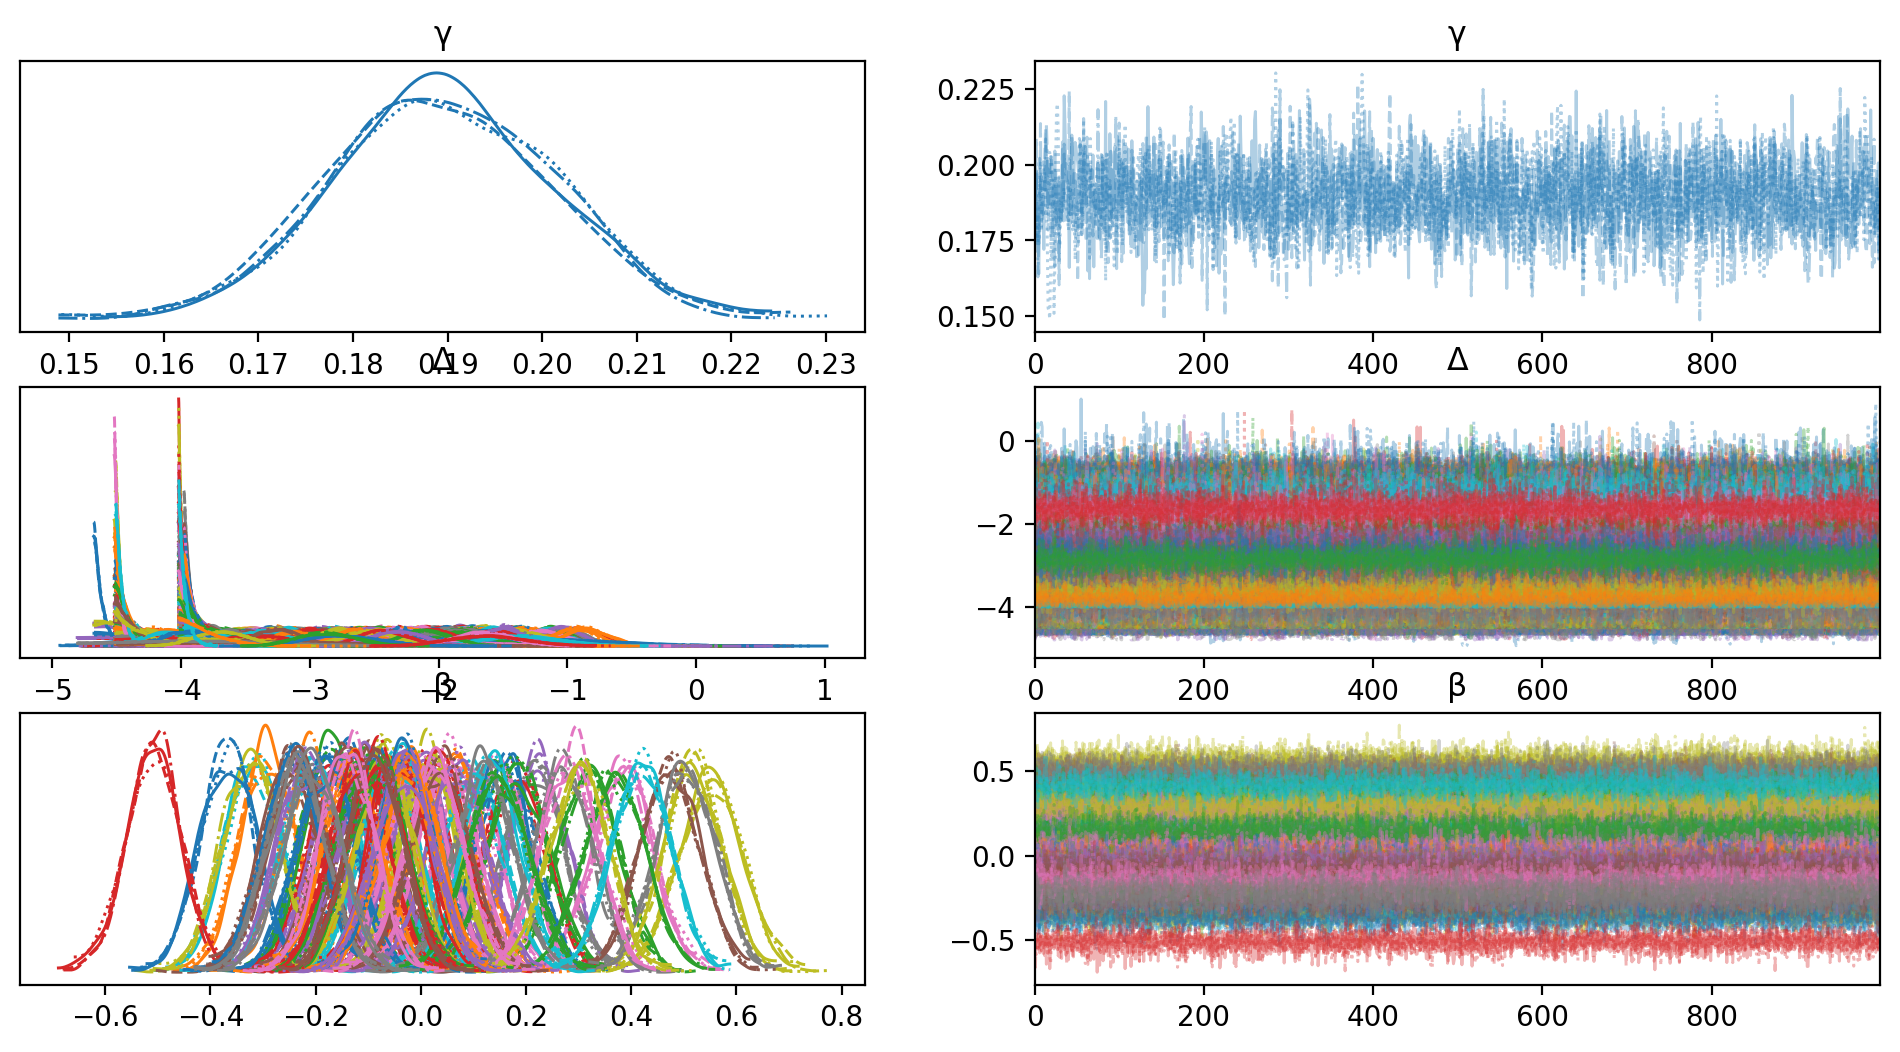

In [20]:
az.plot_trace(idata, var_names=["γ", "Δ", "β"]);

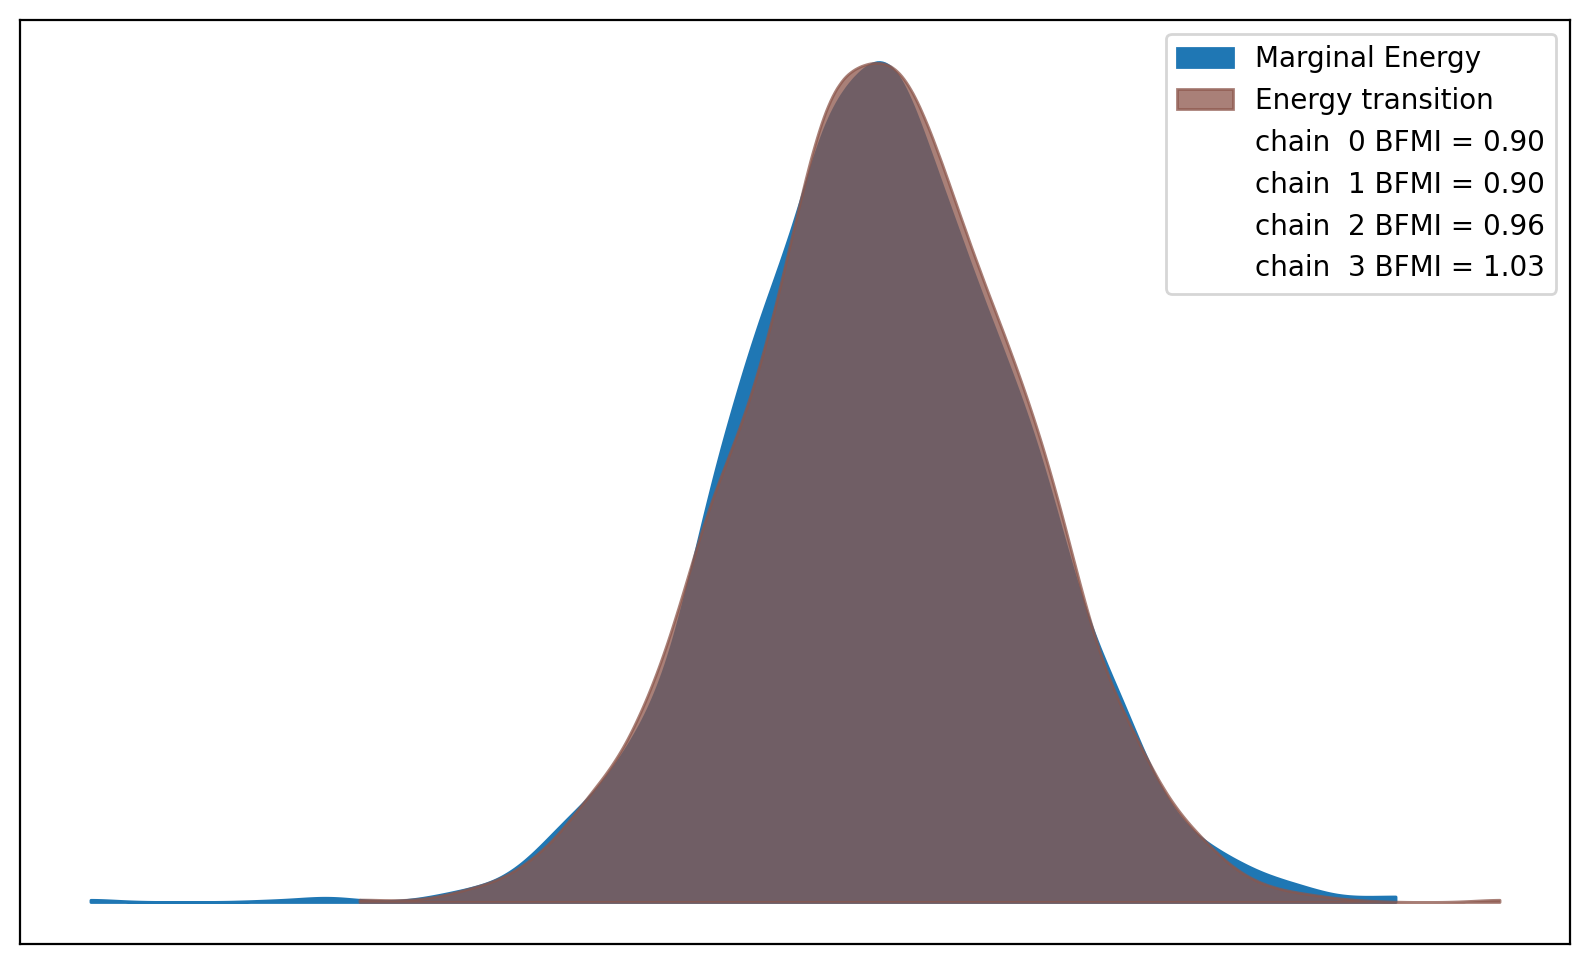

In [21]:
az.plot_energy(idata);

### Model Parameters

In [22]:
az.plot_posterior(idata, var_names=["γ", "Δ", "β"]);

C:\Users\benja\anaconda3\envs\pymc_env_2\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1963) in plot_posterior, generating only 40 plots
  warnings.warn(


In [23]:
# az.plot_forest(idata, var_names=["γ", "Δ", "β"]);

In [24]:
az_summary_Δ = (
    az.
    summary(idata, var_names="Δ")
    .sort_values("mean", ascending=True)
    .assign(
        player_id=lambda x: x.index.str.replace("Δ[", "").str.replace("]", "")
    )
)
az_summary_Δ

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
Δ[57df7a11] -4.625  0.053  -4.680   -4.530      0.001    0.001  4,105.000   
Δ[6813ac34] -4.496  0.130  -4.679   -4.268      0.002    0.001  3,505.000   
Δ[e1cbb531] -4.489  0.030  -4.520   -4.431      0.000    0.000  3,803.000   
Δ[3c7bc9bd] -4.471  0.039  -4.510   -4.401      0.001    0.000  4,866.000   
Δ[e26fcca3] -4.464  0.054  -4.520   -4.368      0.001    0.000  4,357.000   
...            ...    ...     ...      ...        ...      ...        ...   
Δ[eb61713c] -1.024  0.488  -1.932   -0.096      0.006    0.005  6,169.000   
Δ[a6154613] -1.023  0.157  -1.345   -0.746      0.002    0.001  5,897.000   
Δ[e342ad68] -0.934  0.162  -1.227   -0.632      0.002    0.001  6,076.000   
Δ[8d78e732] -0.893  0.169  -1.213   -0.581      0.002    0.002  5,833.000   
Δ[dea698d9] -0.844  0.168  -1.162   -0.533      0.002    0.001  6,908.000   

              ess_tail  r_hat player_id  
Δ[57df7a11]  1,929.000  1.000  57df7a11  
Δ[6813ac34]  2,065.000  1.000  6813ac34  
Δ[e1cbb531]  1,730.000  1.000  e1cbb531  
Δ[3c7bc9bd]  2,016.000  1.000  3c7bc9bd  
Δ[e26fcca3]  1,695.000  1.000  e26fcca3  
...                ...    ...       ...  
Δ[eb61713c]  2,992.000  1.000  eb61713c  
Δ[a6154613]  2,746.000  1.000  a6154613  
Δ[e342ad68]  2,590.000  1.000  e342ad68  
Δ[8d78e732]  2,401.000  1.000  8d78e732  
Δ[dea698d9]  2,466.000  1.000  dea698d9  

[1884 rows x 10 columns]

### Posterior Predictive

In [25]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [x]


In [26]:
df_posterior_predictive = df.copy()
NUM_CHAINS = 4

# add chains to df
df_posterior_predictive_chains = pd.DataFrame(
    [
        [idata.posterior_predictive.sel(chain=c, x_dim_2=r).x.data for c in range(NUM_CHAINS)] 
        for r in range(len(df_posterior_predictive))
    ], columns=[f"pred_npxg_{i}" for i in range(NUM_CHAINS)])
df_posterior_predictive = df_posterior_predictive.join(df_posterior_predictive_chains)

# calculate average of all chains
df_posterior_predictive["pred_npxg"] = 0.0
for i in range(NUM_CHAINS):
    df_posterior_predictive.pred_npxg += np.array(
        [df_posterior_predictive[f"pred_npxg_{i}"][n].mean() for n in range(len(df_posterior_predictive))]
    ) / NUM_CHAINS

In [27]:
# player_ids table
df_posterior_predictive_player_ids = (
    df_posterior_predictive
    .groupby(["player_id"], as_index=False)
    .agg(
        total_minutes=("minutes", sum), 
        total_npxg=("npxg", sum),
        total_pred_npxg=("pred_npxg", sum),
    )
    .assign(
        npxg90=lambda x: (x.total_npxg / x.total_minutes) * 90.0,
        pred_npxg90=lambda x: (x.total_pred_npxg / x.total_minutes) * 90.0,
    )
    .merge(
        az_summary_Δ[["player_id", "mean"]].rename(columns={"mean": "Δ"}),
        how="left",
        on="player_id",
        validate="1:1"
    )
    .assign(eΔ=lambda x: np.exp(x.Δ))
    .sort_values("Δ")
)
df_posterior_predictive_player_ids

player_id  total_minutes  total_npxg  total_pred_npxg  npxg90  \
660   57df7a11      1,870.000       0.000            0.230   0.000   
758   6813ac34      3,289.000       0.400            0.431   0.011   
1656  e1cbb531      3,061.000       0.000            0.396   0.000   
428   3c7bc9bd      2,516.000       0.000            0.335   0.000   
1661  e26fcca3      2,379.000       0.100            0.318   0.004   
...        ...            ...         ...              ...     ...   
1730  eb61713c         29.000       0.500            0.094   1.552   
1227  a6154613      2,899.000      22.500           20.838   0.699   
1671  e342ad68      2,907.000      22.500           20.543   0.697   
1033  8d78e732      2,171.000      22.700           18.941   0.941   
1631  dea698d9      2,285.000      21.600           19.192   0.851   

      pred_npxg90      Δ     eΔ  
660         0.011 -4.625  0.010  
758         0.012 -4.496  0.011  
1656        0.012 -4.489  0.011  
428         0.012 -4.471  0.011  
1661        0.012 -4.464  0.012  
...           ...    ...    ...  
1730        0.290 -1.024  0.359  
1227        0.647 -1.023  0.360  
1671        0.636 -0.934  0.393  
1033        0.785 -0.893  0.409  
1631        0.756 -0.844  0.430  

[1884 rows x 8 columns]

In [28]:
player_id = "242dbdeb"

df_posterior_predictive_player_ids.query("player_id == @player_id")

Empty DataFrame
Columns: [player_id, total_minutes, total_npxg, total_pred_npxg, npxg90, pred_npxg90, Δ, eΔ]
Index: []

In [29]:
sns.kdeplot(idata.posterior.Δ.sel(player_ids=player_id).data.flatten())
plt.xlabel("Δ")
plt.title(player_id);

KeyError: "not all values found in index 'player_ids'. Try setting the `method` keyword argument (example: method='nearest')."